Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/500
240/240 [==============================] - 237s 941ms/step - loss: 5.8837 - accuracy: 0.0078 - val_loss: 5.7473 - val_accuracy: 0.0166
Epoch 2/500
240/240 [==============================] - 223s 929ms/step - loss: 5.7324 - accuracy: 0.0180 - val_loss: 5.6003 - val_accuracy: 0.0298
Epoch 3/500
240/240 [==============================] - 224s 933ms/step - loss: 5.6018 - accuracy: 0.0277 - val_loss: 5.4319 - val_accuracy: 0.0602
Epoch 4/500
240/240 [==============================] - 229s 956ms/step - loss: 5.4626 - accuracy: 0.0437 - val_loss: 5.2387 - val_accuracy: 0.1112
Epoch 5/500
240/240 [==============================] - 233s 973ms/step - loss: 5.3001 - accuracy: 0.0664 - val_loss: 5.0255 - val_accuracy: 0.1579
Epoch 6/500
240/240 [==============================] - 235s 979ms/step - loss: 5.1343 - accuracy: 0.0819 - val_l

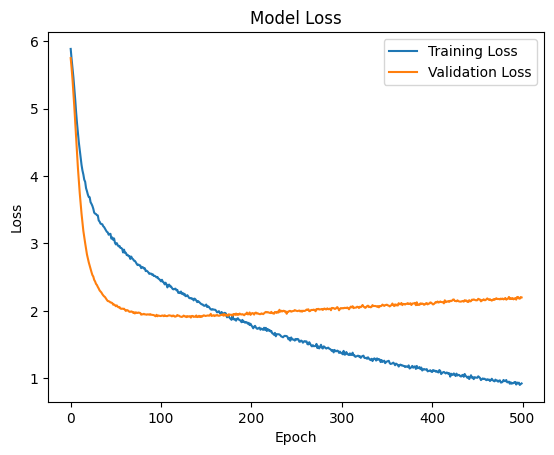

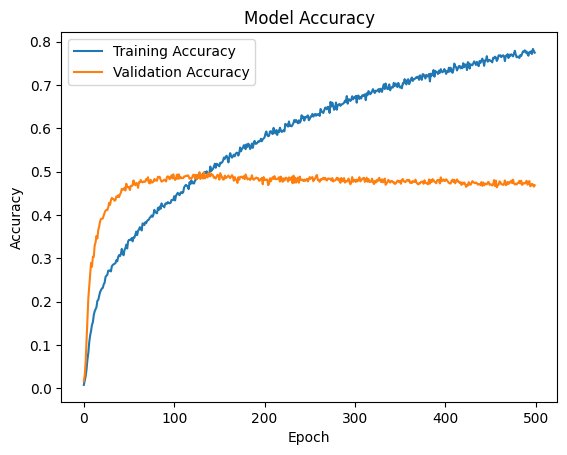

112/112 [==============================] - 22s 180ms/step
Accuracy: 0.46741573033707867
Average Precision: 0.4913870785417843
Average Recall: 0.4617764160721908
Average F1 Score: 0.4363766115788567


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import InceptionV3
from skimage.transform import resize
# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: crop_dog(img, [10, 10, 100, 100])  # Pass the bounding box here
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Adjusted to match the InceptionV3 model input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),  # Adjusted to match the InceptionV3 model input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Function to crop dog from image using bounding box
def crop_dog(img, bbox, target_size=(299, 299)):
    x_min, y_min, width, height = bbox
    cropped_img = img[y_min:y_min+height, x_min:x_min+width]
    resized_img = resize(cropped_img, target_size, anti_aliasing=True)
    return resized_img
    
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(355, activation='softmax')(x)  # Adjust output neurons based on your classification task

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=500,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(355):  # Adjusted based on the number of classes
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print the metrics
print("Accuracy:", accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)
